In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from sklearn.externals import joblib

from dateutil.relativedelta import relativedelta

In [3]:
#Importing train_sub file after all data processing
train_sub = pd.read_feather('grocery_train_raw_final')

## Pre-processing Training Data

In [4]:
mid_month = train_sub.Dayofyear[train_sub.Day == 15].unique()
mid_month

array([228, 259, 289, 320, 350,  15,  46,  74, 105, 135, 166, 196, 227])

In [5]:
end_month = train_sub.Dayofyear[train_sub.Is_month_end == True].unique()
end_month

array([244, 274, 305, 335, 366,  31,  59,  90, 120, 151, 181, 212])

In [6]:
paydates = np.append(mid_month, end_month)
paydates

array([228, 259, 289, 320, 350,  15,  46,  74, 105, 135, 166, 196, 227, 244, 274, 305, 335, 366,  31,  59,
        90, 120, 151, 181, 212])

In [7]:
#Adding pay days data to train_sub 
train_sub['PayDay'] = np.where(np.isin(train_sub.Dayofyear, paydates), 1, 0)

In [8]:
train_sub.Dayofyear[train_sub.PayDay == 1].unique()

array([228, 244, 259, 274, 289, 305, 320, 335, 350, 366,  15,  31,  46,  59,  74,  90, 105, 120, 135, 151,
       166, 181, 196, 212, 227])

In [9]:
# For every store, add total number of sales
sales_by_store = train_sub.groupby(by=['store_nbr'], as_index=False)['unit_sales'].sum()

In [10]:
#Checking whether unit_sales are integers
train_sub.unit_sales[train_sub.unit_sales%1 != 0].head(5)

5       4.994
109     2.610
229     4.583
233     3.747
234    21.466
Name: unit_sales, dtype: float32

In [11]:
sales_by_store = sales_by_store.rename(columns = {'unit_sales':'total_store_sales'})

In [12]:
train_sub = pd.merge(train_sub, sales_by_store, how='left', on=['store_nbr'])

In [13]:
train_sub.total_store_sales.head(5)

0    4756712.5
1    4756712.5
2    4756712.5
3    4756712.5
4    4756712.5
Name: total_store_sales, dtype: float32

In [14]:
# Number of times every item in every store was returned
num_return_store = train_sub.groupby(by='store_nbr', as_index=False)['was_returned'].sum()

In [15]:
num_return_store.was_returned.unique()    

array([  84.,   65.,  120.,   88.,   32.,   64.,   90.,   70.,   13.,   15.,   25.,   29.,   17.,   22.,
        135.,   24.,   37.,   42.,   19.,   57.,  114.,   55.,   20.,   50.,   26.,   38.,   36.,   27.,
         45.,  143.,   72.,  115.,   51.,   83.,    7.,   16.])

In [16]:
num_return_store = num_return_store.rename(columns = {'was_returned':'ret_frq_by_store'})

(array([ 12.,  15.,   9.,   4.,   5.,   3.,   1.,   2.,   1.,   2.]),
 array([   7. ,   20.6,   34.2,   47.8,   61.4,   75. ,   88.6,  102.2,  115.8,  129.4,  143. ]),
 <a list of 10 Patch objects>)

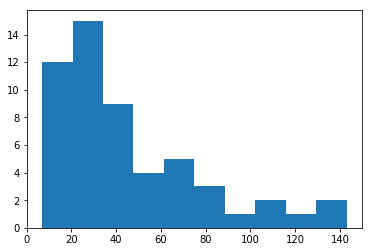

In [17]:
plt.hist(num_return_store.ret_frq_by_store)

In [18]:
train_sub = pd.merge(train_sub, num_return_store, how='left', on=['store_nbr'])

In [19]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,type,...,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,PayDay,total_store_sales,ret_frq_by_store
0,88106511,38,1998889,2.0,0,0,1301.0,Loja,Loja,D,...,False,False,False,False,False,False,1471219200,1,4756712.5,45.0
1,88106510,38,1998005,4.0,0,0,1301.0,Loja,Loja,D,...,False,False,False,False,False,False,1471219200,1,4756712.5,45.0
2,88106509,38,1997976,1.0,0,0,1301.0,Loja,Loja,D,...,False,False,False,False,False,False,1471219200,1,4756712.5,45.0
3,88106508,38,1997895,1.0,0,0,1301.0,Loja,Loja,D,...,False,False,False,False,False,False,1471219200,1,4756712.5,45.0
4,88106507,38,1994863,9.0,0,0,1301.0,Loja,Loja,D,...,False,False,False,False,False,False,1471219200,1,4756712.5,45.0


In [20]:
# Number of times every item by item number was returned
num_return_item = train_sub.groupby(by='item_nbr', as_index=False)['was_returned'].sum()

In [21]:
num_return_item.was_returned.unique()    # array([0, 1, 2, 3, 6, 4, 5])

array([ 0,  1,  2,  3, 18,  5,  4,  8,  6, 13, 19, 10, 46,  9, 12,  7, 22, 11, 65])

In [22]:
num_return_item = num_return_item.rename(columns = {'was_returned':'ret_frq_by_item'})

(array([ 4017.,    12.,     4.,     1.,     0.,     0.,     0.,     1.,     0.,     1.]),
 array([  0. ,   6.5,  13. ,  19.5,  26. ,  32.5,  39. ,  45.5,  52. ,  58.5,  65. ]),
 <a list of 10 Patch objects>)

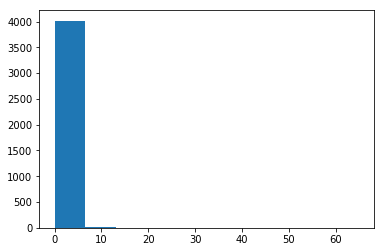

In [23]:
plt.hist(num_return_item.ret_frq_by_item)

In [24]:
train_sub = pd.merge(train_sub, num_return_item, how='left', on=['item_nbr'])

In [25]:
train_sub.dtypes

id                       int32
store_nbr                 int8
item_nbr                 int32
unit_sales             float32
onpromotion               int8
was_returned              int8
transactions           float64
city                  category
state                 category
type                  category
cluster                  int64
family                category
class                    int64
perishable               int64
dcoilwtico             float32
holiday_type_city     category
description_city      category
holiday_type_state    category
description_state     category
holiday_type_nat      category
description_nat       category
Year                     int64
Month                    int64
Week                     int64
Day                      int64
Dayofweek                int64
Dayofyear                int64
Is_month_end              bool
Is_month_start            bool
Is_quarter_end            bool
Is_quarter_start          bool
Is_year_end               bool
Is_year_

In [26]:
#Dropping was_returned column
train_sub.drop('was_returned', axis=1, inplace=True)

In [27]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,transactions,city,state,type,cluster,...,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,PayDay,total_store_sales,ret_frq_by_store,ret_frq_by_item
0,88106511,38,1998889,2.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,1,4756712.5,45.0,1
1,88106510,38,1998005,4.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,1,4756712.5,45.0,0
2,88106509,38,1997976,1.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,1,4756712.5,45.0,2
3,88106508,38,1997895,1.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,1,4756712.5,45.0,0
4,88106507,38,1994863,9.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,1,4756712.5,45.0,0


In [28]:
#Not setting one-hot encoding -> max_n_cat = 7
df_trn, y_trn, _ = proc_df(train_sub, 'unit_sales')

In [29]:
df_trn['date'] = pd.to_datetime(pd.DataFrame({'year': train_sub.Year.tolist(),
                                              'month': train_sub.Month.tolist(),
                                              'day': train_sub.Day.tolist()}))

In [30]:
y_trn = np.log1p(np.clip(y_trn, 0, None))

## Pre-processing Test Data

In [31]:
grocery_test = pd.read_feather('grocery_test_final')

In [32]:
#Imputing ret_frq_by_item in grocery_test since there are NAs
ret_frq_median = grocery_test.groupby(['item_nbr', 'Year', 'Month'], as_index=False)[['ret_frq_by_item']].median()
ret_frq_median.columns = ['item_nbr', 'Year', 'Month','ret_frq_med']
ret_frq_median.fillna(0, inplace = True)

In [33]:
ret_frq_median.columns[ret_frq_median.isnull().any()]

Index([], dtype='object')

In [34]:
grocery_test = pd.merge(grocery_test, ret_frq_median, how='left', on=['item_nbr', 'Year', 'Month'])
grocery_test['ret_frq_by_item'].fillna(grocery_test['ret_frq_med'], inplace=True)
grocery_test.drop('ret_frq_med', axis=1, inplace=True)
grocery_test.head(1).dtypes

id                       int64
store_nbr                int64
item_nbr                 int64
onpromotion               int8
city                  category
state                 category
type                  category
cluster                  int64
family                category
class                    int64
perishable               int64
dcoilwtico             float32
holiday_type_city     category
description_city      category
holiday_type_state    category
description_state     category
holiday_type_nat      category
description_nat       category
Year                     int64
Month                    int64
Week                     int64
Day                      int64
Dayofweek                int64
Dayofyear                int64
Is_month_end              bool
Is_month_start            bool
Is_quarter_end            bool
Is_quarter_start          bool
Is_year_end               bool
Is_year_start             bool
Elapsed                  int64
ret_frq_by_store       float64
ret_frq_

In [35]:
def add_dum_col(df):
    df['dummy'] = 1
    df_new, _, _ = proc_df(df, 'dummy')
    return df_new

In [36]:
grocery_test = add_dum_col(grocery_test)

In [37]:
#Dropping oil variable
grocery_test.drop('dcoilwtico', axis = 1, inplace = True)

In [38]:
#Dropping oil variable
df_trn.drop('dcoilwtico', axis = 1, inplace = True)

In [39]:
grocery_test.head(1)

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,...,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item,total_store_sales,PayDay,transactions
0,125497040,1,96995,0,19,13,4,13,13,1093,...,False,False,False,False,1502841600,84.0,0.0,3905175.25,1,1568.766324


In [40]:
df_trn.head(1)

,id,store_nbr,item_nbr,onpromotion,transactions,city,state,type,cluster,family,...,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,PayDay,total_store_sales,ret_frq_by_store,ret_frq_by_item,date
0,88106511,38,1998889,0,1301.0,13,9,4,4,4,...,False,False,False,False,1471219200,1,4756712.5,45.0,1,2016-08-15


## Performing k-fold Cross Validation

In [41]:
def split_vals(a,n1,n2): return a[0:n1].copy(), a[n1:n2].copy()

In [42]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [70]:
#Perform k-fold cross-validation with Random Forest parameters
def cross_val_rf(df, y, n_months,n_days, n_est, min_sam_leaf):
    
    n_folds = int(n_months*30.0/n_days)
    errors = []
    fis = []
    first_dt_train = df.date.min() # First date available in the training set (train.csv)
    
    #Setting seed
    random.seed(9001)
    
    #Sequentially split available training dataset into train and validation sets
    for i in range(1,n_folds):
        
        set_rf_samples(1_000_000)
        # Initialize random forest
        m_kcv = RandomForestRegressor(n_estimators = n_est, max_features = 0.5, min_samples_leaf = min_sam_leaf, n_jobs=-1, oob_score = False)
        
        #Getting dates for training and validation sets
        train_sub_startdt = first_dt_train + relativedelta(days = i*n_days)
        valid_sub_startdt = first_dt_train + relativedelta(days = (i+1)*n_days)
        
        #Create indices for training and validation sets
        index_train = sorted(df.index[df['date'] == train_sub_startdt].tolist())[0]
        index_valid = sorted(df.index[df['date'] == valid_sub_startdt].tolist())[0]
        
        #Create subsetted dataframes of X,y, and w for training and validation sets
        X_train, X_valid = split_vals(df.loc[:, df.columns != 'date'], index_train, index_valid)
        y_train, y_valid = split_vals(y, index_train, index_valid)
        print(X_train.shape, y_train.shape, X_valid.shape)
        
        # Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
        item_weight_train = 1 + X_train['perishable'] * 0.25
        item_weight_valid = 1 + X_valid['perishable'] * 0.25
              
        #Optimizing the model fit by converting it to float array outside
        X_train= np.array(X_train, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv.fit(X_train, y_train)
        
        #Print the NWRMSLE score and R-squared values for training and validation sets
        %time combo_print_score(m_kcv, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid)
        print('\n\n')
        
        #Add errors to the errors list
        errors.append([get_score(m_kcv, X_train, y_train, item_weight_train), get_score(m_kcv, X_valid, y_valid, item_weight_valid)])
        
        #Feature importance
        fi = rf_feat_importance(m_kcv, df.loc[:, df.columns != 'date'])
        print(fi[:10])
        #fi.plot('cols', 'imp', figsize=(10,6), legend=False)
        #plot_fi(fi[:30])
        fis.append(fi[:10])
        
        #Reducing number of features
        to_keep = fi[fi.imp>0.005].cols
        df_keep = df[to_keep].copy()
        
        #Training on training set again
        #Create subsetted dataframes of X,y, and w for training and validation sets
        X_train, X_valid = split_vals(df_keep.loc[:, df_keep.columns != 'date'], index_train, index_valid)
        y_train, y_valid = split_vals(y, index_train, index_valid)
        print(X_train.shape, y_train.shape, X_valid.shape)
        
        # Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
        item_weight_train = 1 + X_train['perishable'] * 0.25
        item_weight_valid = 1 + X_valid['perishable'] * 0.25
              
        #Optimizing the model fit by converting it to float array outside
        X_train= np.array(X_train, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv.fit(X_train, y_train)
        
        #Print the NWRMSLE score and R-squared values for training and validation sets
        %time combo_print_score(m_kcv, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid)
        print('\n\n')
        
        #Add errors to the errors list
        errors.append([get_score(m_kcv, X_train, y_train, item_weight_train), get_score(m_kcv, X_valid, y_valid, item_weight_valid)])  
        
        ##Train on entire training set
        # Initialize random forest
        m_kcv_new = RandomForestRegressor(n_estimators = n_est, max_features = 0.5, min_samples_leaf = min_sam_leaf, n_jobs=-1, oob_score = False)
        
        X_train_new = df_keep.loc[:, df_keep.columns != 'date'][:index_valid]
        y_train_new = y[:index_valid]
        print(X_train_new.shape, y_train_new.shape)
              
        # Compute arrays of item score weights for the items in the training set (for which we will make predictions)
        item_weight_train_new = 1 + X_train_new['perishable'] * 0.25
        
        #Optimizing the model fit by converting it to float array outside
        X_train_new = np.array(X_train_new, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv_new.fit(X_train_new, y_train_new)
        
        #Subset test set
        grocery_test_keep = grocery_test[to_keep].copy()
        
        #Predict for test set
        pred_test_log = m_kcv_new.predict(grocery_test_keep)
        pred_test = np.round(np.expm1(pred_test_log), decimals=0)
        output = pd.concat([grocery_test_keep['id'],pd.DataFrame(pred_test)],axis=1)
        output.columns = ['id','unit_sales']
        name = 'pred_' + str(i) + '.csv' 
        output.to_csv(name,index=False)
        
    #Write errors to file
    with open('errors_forward.txt', 'w') as file:
        file.write(str(errors))
    
    #Write feature importances to file
    with open('fi_forward.txt', 'w') as file:
        file.write(str(fis))

## Performing Backward k-fold Cross-Validation

In [44]:
def split_vals_back(a,n1,n2): return a[n1:n2].copy(), a[n2:].copy()

In [74]:
#Perform k-fold cross-validation with Random Forest parameters
def cross_val_rf_back(df, y, n_months,n_days, n_est, min_sam_leaf):
    
    n_folds = int(n_months*30.0/n_days)
    errors = []
    fis = []
    last_dt_train = df.date.max() # Last date available in the training set (train.csv)
    
    #Setting seed
    random.seed(9001)
    
    #Sequentially split available training dataset into train and validation sets
    for i in range(1,n_folds):
        
        set_rf_samples(1_000_000)
        # Initialize random forest
        m_kcv_back = RandomForestRegressor(n_estimators = n_est, max_features = 0.5, min_samples_leaf = min_sam_leaf, n_jobs=-1, oob_score = False)
        
        #Getting dates for training and validation sets
        train_sub_startdt = last_dt_train - relativedelta(days = (i+1)*n_days)
        valid_sub_startdt = last_dt_train - relativedelta(days = n_days)
        
        #Create indices for training and validation sets
        index_train = sorted(df.index[df['date'] == train_sub_startdt].tolist())[0]
        index_valid = sorted(df.index[df['date'] == valid_sub_startdt].tolist())[0]
        
        #Create subsetted dataframes of X,y, and w for training and validation sets
        X_train, X_valid = split_vals_back(df.loc[:, df.columns != 'date'], index_train, index_valid)
        y_train, y_valid = split_vals_back(y, index_train, index_valid)
        print(X_train.shape, y_train.shape, X_valid.shape)
        
        # Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
        item_weight_train = 1 + X_train['perishable'] * 0.25
        item_weight_valid = 1 + X_valid['perishable'] * 0.25
              
        #Optimizing the model fit by converting it to float array outside
        X_train= np.array(X_train, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv_back.fit(X_train, y_train)
        
        #Print the NWRMSLE score and R-squared values for training and validation sets
        %time combo_print_score(m_kcv_back, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid)
        print('\n\n')
        
        #Add errors to the errors list
        errors.append([get_score(m_kcv_back, X_train, y_train, item_weight_train), get_score(m_kcv_back, X_valid, y_valid, item_weight_valid)])
        
        #Feature importance
        fi = rf_feat_importance(m_kcv_back, df.loc[:, df.columns != 'date'])
        print(fi[:10])
        #fi.plot('cols', 'imp', figsize=(10,6), legend=False)
        #plot_fi(fi[:30])
        fis.append(fi[:10])
        
        #Reducing number of features
        to_keep = fi[fi.imp>0.005].cols
        df_keep = df[to_keep].copy()
        
        #Training on training set again
        #Create subsetted dataframes of X,y, and w for training and validation sets
        X_train, X_valid = split_vals_back(df_keep.loc[:, df_keep.columns != 'date'], index_train, index_valid)
        y_train, y_valid = split_vals_back(y, index_train, index_valid)
        print(X_train.shape, y_train.shape, X_valid.shape)
        
        # Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
        item_weight_train = 1 + X_train['perishable'] * 0.25
        item_weight_valid = 1 + X_valid['perishable'] * 0.25
              
        #Optimizing the model fit by converting it to float array outside
        X_train= np.array(X_train, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv_back.fit(X_train, y_train)
        
        #Print the NWRMSLE score and R-squared values for training and validation sets
        %time combo_print_score(m_kcv_back, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid)
        print('\n\n')
        
        #Add errors to the errors list
        errors.append([get_score(m_kcv_back, X_train, y_train, item_weight_train), get_score(m_kcv_back, X_valid, y_valid, item_weight_valid)])
      
        ##Train on entire training set
        # Initialize random forest
        m_kcv_back_new = RandomForestRegressor(n_estimators = n_est, max_features = 0.5, min_samples_leaf = min_sam_leaf, n_jobs=-1, oob_score = False)
        
        X_train_new = df_keep.loc[:, df_keep.columns != 'date'][index_train:]
        y_train_new = y[index_train:]
        print(X_train_new.shape, y_train_new.shape)
        
        # Compute arrays of item score weights for the items in the training set (for which we will make predictions)
        item_weight_train_new = 1 + X_train_new['perishable'] * 0.25
        
        #Optimizing the model fit by converting it to float array outside
        X_train_new = np.array(X_train_new, dtype=np.float32)
        
        # Fit the random forest model on training set w/ cross validation
        %time m_kcv_back_new.fit(X_train_new, y_train_new)
        
        #Subset test set
        grocery_test_keep = grocery_test[to_keep].copy()
        
        #Predict for test set
        pred_test_log = m_kcv_back_new.predict(grocery_test_keep)
        pred_test = np.round(np.expm1(pred_test_log), decimals=0)
        output = pd.concat([grocery_test_keep['id'],pd.DataFrame(pred_test)],axis=1)
        output.columns = ['id','unit_sales']
        name = 'pred_back_' + str(i) + '.csv' 
        output.to_csv(name,index=False)
        
    #Write errors to file
    with open('errors_backward.txt', 'w') as file:
        file.write(str(errors))
    
    #Write feature importances to file
    with open('fi_backward.txt', 'w') as file:
        file.write(str(fis))

## Scoring Metric for the Fitted Model

In [46]:
# Computes and returns NWRMSLE score and R-squared values
def get_score(model, X, y, weights):
    # Predicting for the input data
    y_hat = model.predict(X)
    # Calculating the residuals
    rsquared = model.score(X, y)
    # Specified score (from Kaggle)
    nwrmsle = math.sqrt(np.sum(np.multiply(weights, np.square(y_hat - y))) / np.sum(weights))
    res = [nwrmsle, rsquared]
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    return res

def combo_print_score(model, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid):
    print('For training set: (nwrmsle, rsquared)')
    print(get_score(model, X_train, y_train, item_weight_train))
    print('For validation set: (nwrmsle, rsquared)')
    print(get_score(model, X_valid, y_valid, item_weight_valid))

## Run Cross-Validation

In [72]:
cross_val_rf(df_trn, y_trn, n_months=2,n_days=15, n_est = 80, min_sam_leaf = 3)

(1426858, 35) (1426858,) (1452701, 35)
CPU times: user 11min 20s, sys: 2.36 s, total: 11min 22s
Wall time: 22.5 s
For training set: (nwrmsle, rsquared)
[0.4080954400144813, 0.76869026880564684]
For validation set: (nwrmsle, rsquared)
[0.5743583225252505, 0.56245012371184955]
CPU times: user 2min 50s, sys: 4.3 s, total: 2min 54s
Wall time: 10.8 s



                 cols       imp
2            item_nbr  0.310675
10              class  0.189283
4        transactions  0.088465
9              family  0.069642
0                  id  0.067279
32  total_store_sales  0.054941
34    ret_frq_by_item  0.037160
33   ret_frq_by_store  0.028394
1           store_nbr  0.023018
3         onpromotion  0.022150
(1426858, 19) (1426858,) (1452701, 19)
CPU times: user 9min 8s, sys: 3.38 s, total: 9min 12s
Wall time: 18.8 s
For training set: (nwrmsle, rsquared)
[0.4073579370734571, 0.76951050042170277]
For validation set: (nwrmsle, rsquared)
[0.5729704881533401, 0.56456866122112925]
CPU times: user 2min 48s

In [75]:
cross_val_rf_back(df_trn, y_trn, n_months=2,n_days=15, n_est = 80, min_sam_leaf = 3)

(1571120, 35) (1571120,) (1677344, 35)
CPU times: user 11min 25s, sys: 3.87 s, total: 11min 29s
Wall time: 23 s
For training set: (nwrmsle, rsquared)
[0.4383095341350787, 0.74779588928904983]
For validation set: (nwrmsle, rsquared)
[0.6014039181723291, 0.51307119934266499]
CPU times: user 2min 59s, sys: 8.2 s, total: 3min 7s
Wall time: 13.7 s



                 cols       imp
2            item_nbr  0.292627
10              class  0.183817
4        transactions  0.101059
0                  id  0.074593
9              family  0.066240
32  total_store_sales  0.048522
34    ret_frq_by_item  0.039142
3         onpromotion  0.037239
33   ret_frq_by_store  0.025414
22          Dayofweek  0.022295
(1571120, 19) (1571120,) (1677344, 19)
CPU times: user 10min 6s, sys: 4.06 s, total: 10min 10s
Wall time: 20.2 s
For training set: (nwrmsle, rsquared)
[0.4422267702393719, 0.7432883193598655]
For validation set: (nwrmsle, rsquared)
[0.6045717649071254, 0.50796185339607502]
CPU times: user 2min 50s, 